In [65]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)
    
class CnnPolicy(nn.Module):
    def __init__(self, ob_space, ac_space):
        super(CnnPolicy, self).__init__()
        nh, nw, nc = ob_space.shape
        nact = ac_space.n
        
        self.conv1 = nn.Conv2d(nc, 8, 5)
        self.conv2 = nn.Conv2d(8, 16, 5)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.conv4 = nn.Conv2d(32, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, nact)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 64 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
class 

torch.Size([1, 10])

In [74]:
import gym
env = gym.make("Pong-v0")
observation = env.reset()

model = CnnPolicy(env.observation_space, env.action_space)

for _ in range(10000):
    env.render()
    action = env.action_space.sample() # your agent here (this takes random actions)
    observation, reward, done, info = env.step(action)

    if done:
        observation = env.reset()
env.close()

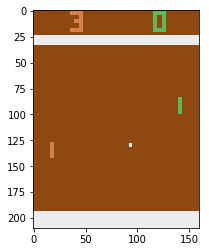

In [8]:
import matplotlib.pyplot as plt
plt.imshow(observation)

In [73]:
env.observation_space.shape

(210, 160, 3)